# RL CIA-2 Vaibhav 21011101136

## Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Step 1: Define the Grid Environment with obstacles
class GridEnvironment:
    def __init__(self, size=100, obstacle_prob=0.2):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (random.randint(0, size-1), random.randint(0, size-1))
        self.goal = (random.randint(0, size-1), random.randint(0, size-1))
        
        # Set obstacles
        for i in range(size):
            for j in range(size):
                if random.random() < obstacle_prob and (i, j) != self.start and (i, j) != self.goal:
                    self.grid[i, j] = -1  # Represent obstacles by -1

    def is_obstacle(self, state):
        return self.grid[state] == -1

    def is_terminal(self, state):
        return state == self.goal

In [3]:
# Step 2: Define MDP Transition and Reward Functions
class MDP:
    def __init__(self, env):
        self.env = env
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
    
    def transition(self, state, action):
        next_state = (state[0] + action[0], state[1] + action[1])
        if 0 <= next_state[0] < self.env.size and 0 <= next_state[1] < self.env.size:
            if not self.env.is_obstacle(next_state):
                return next_state
        return state  # Stay in place if hitting an obstacle or boundary

    def reward(self, state, action, next_state):
        return 1 if next_state == self.env.goal else -0.1  # Small penalty for each step


In [4]:
# Step 3: Implement Policy Iteration Agent
class PolicyIterationAgent:
    def __init__(self, mdp, gamma=0.9, theta=1e-3):
        self.mdp = mdp
        self.gamma = gamma
        self.theta = theta
        self.value_table = np.zeros((self.mdp.env.size, self.mdp.env.size))
        self.policy = np.random.choice(range(len(self.mdp.actions)), (self.mdp.env.size, self.mdp.env.size))
    
    def policy_evaluation(self):
        while True:
            delta = 0
            for i in range(self.mdp.env.size):
                for j in range(self.mdp.env.size):
                    state = (i, j)
                    if self.mdp.env.is_terminal(state) or self.mdp.env.is_obstacle(state):
                        continue
                    
                    action = self.mdp.actions[self.policy[i, j]]
                    next_state = self.mdp.transition(state, action)
                    reward = self.mdp.reward(state, action, next_state)
                    
                    v = self.value_table[i, j]
                    self.value_table[i, j] = reward + self.gamma * self.value_table[next_state]
                    delta = max(delta, abs(v - self.value_table[i, j]))
            if delta < self.theta:
                break

    def policy_improvement(self):
        policy_table = True
        for i in range(self.mdp.env.size):
            for j in range(self.mdp.env.size):
                state = (i, j)
                if self.mdp.env.is_terminal(state) or self.mdp.env.is_obstacle(state):
                    continue
                
                old_action = self.policy[i, j]
                action_values = []
                for action in self.mdp.actions:
                    next_state = self.mdp.transition(state, action)
                    reward = self.mdp.reward(state, action, next_state)
                    action_values.append(reward + self.gamma * self.value_table[next_state])
                
                self.policy[i, j] = np.argmax(action_values)
                if old_action != self.policy[i, j]:
                    policy_table = False
        return policy_table

    def policy_iteration(self):
        while True:
            self.policy_evaluation()
            if self.policy_improvement():
                break

In [5]:
# Step 4: Implement Q-Learning Agent
class QLearningAgent:
    def __init__(self, mdp, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
        self.mdp = mdp
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes
        self.q_table = np.zeros((self.mdp.env.size, self.mdp.env.size, len(self.mdp.actions)))
    
    def train(self):
        for episode in range(self.episodes):
            state = self.mdp.env.start
            while not self.mdp.env.is_terminal(state):
                if random.uniform(0, 1) < self.epsilon:
                    action_idx = random.randint(0, len(self.mdp.actions) - 1)
                else:
                    action_idx = np.argmax(self.q_table[state[0], state[1]])
                
                action = self.mdp.actions[action_idx]
                next_state = self.mdp.transition(state, action)
                reward = self.mdp.reward(state, action, next_state)
                
                best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
                td_target = reward + self.gamma * self.q_table[next_state[0], next_state[1], best_next_action]
                td_delta = td_target - self.q_table[state[0], state[1], action_idx]
                self.q_table[state[0], state[1], action_idx] += self.alpha * td_delta
                
                state = next_state

In [6]:
# Initialize environment and MDP
env = GridEnvironment()
mdp = MDP(env)

pi_agent = PolicyIterationAgent(mdp)
pi_agent.policy_iteration()

ql_agent = QLearningAgent(mdp)
ql_agent.train()

print("Policy Iteration Value Table:", pi_agent.value_table)
print("Q-Learning Q-Table:", ql_agent.q_table)

Policy Iteration Value Table: [[-0.99999966 -0.99999962  0.         ... -0.99999619 -0.99999657
   0.        ]
 [-0.99999962 -0.99999958 -0.99999954 ... -0.99999576 -0.99999619
  -0.99999657]
 [ 0.         -0.99999954 -0.99999948 ... -0.99999529 -0.99999576
  -0.99999619]
 ...
 [-0.99887216 -0.99898494  0.         ...  0.         -0.98854717
  -0.98969245]
 [-0.99898494  0.         -0.99845289 ... -0.98854717 -0.98969245
   0.        ]
 [-0.99908645 -0.9991778   0.         ... -0.98727463 -0.98854717
  -0.98969245]]
Q-Learning Q-Table: [[[-0.91897283 -0.9181748  -0.91876459 -0.91844505]
  [-0.9188313  -0.91902157 -0.91862509 -0.91827142]
  [ 0.          0.          0.          0.        ]
  ...
  [-0.83053387 -0.83108787 -0.83056282 -0.82980227]
  [-0.83290873 -0.83057148 -0.8317248  -0.83178645]
  [ 0.          0.          0.          0.        ]]

 [[-0.91865151 -0.91829365 -0.91846195 -0.91820572]
  [-0.91884247 -0.91869865 -0.91841356 -0.91865635]
  [-0.91857242 -0.91931178 -0.9185

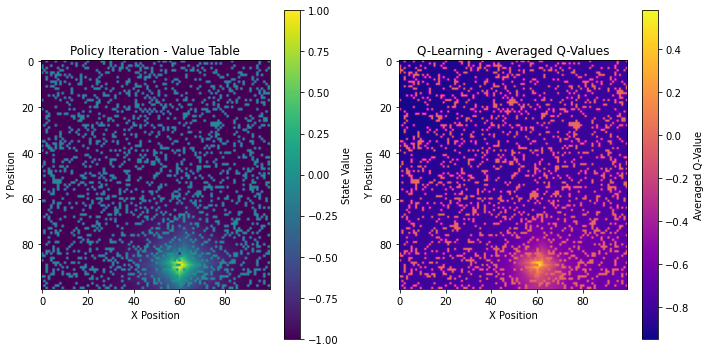

In [7]:
def plot_results(policy_table, q_table):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Policy Iteration - Value Table")
    plt.imshow(policy_table, cmap="viridis")
    plt.colorbar(label="State Value")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")

    avg_q_values = np.mean(q_table, axis=2)

    plt.subplot(1, 2, 2)
    plt.title("Q-Learning - Averaged Q-Values")
    plt.imshow(avg_q_values, cmap="plasma")
    plt.colorbar(label="Averaged Q-Value")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")

    plt.tight_layout()
    plt.show()

plot_results(pi_agent.value_table, ql_agent.q_table)